In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import (
    mean_absolute_percentage_error,
    mean_absolute_error,
)

import torch.nn as nn
import torch.nn.functional as F

In [126]:
# seq values 
row_count = 500
val_count = 100
test_count =100
N_LAGS =4
N_STEPS = 1

SPLIT_RATIOS = [0.80,0.10,0.10]
TRAIN_ROW_CNT = int(row_count*SPLIT_RATIOS[0])
VAL_ROW_CNT = int(row_count*SPLIT_RATIOS[1])
TEST_ROW_CNT = int(row_count*SPLIT_RATIOS[2])

val_st, val_end = TRAIN_ROW_CNT+N_LAGS, TRAIN_ROW_CNT+VAL_ROW_CNT

data=pd.DataFrame({'seq_values':np.sin(list(range(row_count))) })

for lag in range(1,N_LAGS+1):
    data[f'lag_{lag}'] = data['seq_values'].shift(lag)
data = data.dropna().reset_index(drop=True)

FEAT_COLS = [f'lag_{lag}' for lag in range(N_STEPS,N_LAGS+1)]
TGT_COLS = ['seq_values']


train_data = data.iloc[:val_st]
val_data = data.iloc[val_st:val_end]
test_data =  data.iloc[val_end:]

data.head()

,seq_values,lag_1,lag_2,lag_3,lag_4
0,-0.756802,0.141120,0.909297,0.841471,0.000000
1,-0.958924,-0.756802,0.141120,0.909297,0.841471
2,-0.279415,-0.958924,-0.756802,0.141120,0.909297
3,0.656987,-0.279415,-0.958924,-0.756802,0.141120
4,0.989358,0.656987,-0.279415,-0.958924,-0.756802


In [11]:
def get_batch_indexes(batch_size, data_len, train_len):
    total_batches = train_len//batch_size

    batch_indexes = np.column_stack((np.arange(start=0,stop=data_len, step=batch_size),
               np.arange(start=0+batch_size,stop=data_len+batch_size, step=batch_size)))
    return batch_indexes[:total_batches]


def get_data_loader(tgt_data:pd.DataFrame, feat_data:pd.DataFrame, batch_size, shuffle, is_rnn = False):
    tgt_tensor = torch.tensor(tgt_data.to_numpy(), dtype= torch.float32)
    feat_tensor = torch.tensor(feat_data.to_numpy(), dtype= torch.float32)
    if is_rnn:
        feat_tensor = feat_tensor.unsqueeze(2)
    dataset = torch.utils.data.TensorDataset(tgt_tensor, feat_tensor)
    dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                             batch_size=batch_size, 
                                             shuffle=shuffle)
    
    return dataset, dataloader

In [58]:
class CustRNN(nn.Module):
    def __init__(self, input_shape,out_len, rnn_hidden_size, rnn_layers):
        super(CustRNN, self).__init__()
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_layers = rnn_layers

        self.rnn_layer = nn.RNN(input_size=input_shape,
                                hidden_size=rnn_hidden_size,
                                num_layers=rnn_layers, 
                                nonlinearity='relu', 
                                batch_first=True)
        self.layer_1 =  nn.Linear(rnn_hidden_size, out_len)

    def forward(self, input):
        hidden_prev = torch.zeros(self.rnn_layers,
                                  input.size(0),
                                  self.rnn_hidden_size).to(input.device)
        rnn_out, hidden_nxt = self.rnn_layer(input,hidden_prev)
        x = self.layer_1(rnn_out[:,-1,:])

        return x
    


In [127]:
train_data

,seq_values,lag_1,lag_2,lag_3,lag_4
0,-0.756802,0.141120,0.909297,0.841471,0.000000
1,-0.958924,-0.756802,0.141120,0.909297,0.841471
2,-0.279415,-0.958924,-0.756802,0.141120,0.909297
3,0.656987,-0.279415,-0.958924,-0.756802,0.141120
4,0.989358,0.656987,-0.279415,-0.958924,-0.756802
...,...,...,...,...,...
399,0.768274,-0.123543,-0.901775,-0.850919,-0.017732
400,0.953744,0.768274,-0.123543,-0.901775,-0.850919
401,0.262346,0.953744,0.768274,-0.123543,-0.901775
402,-0.670252,0.262346,0.953744,0.768274,-0.123543


In [59]:
trn_data, train_loader = get_data_loader(tgt_data=train_data[TGT_COLS], 
                feat_data=train_data[FEAT_COLS],
                batch_size=10,
                shuffle=False,
                is_rnn=True)

In [104]:
# training using the entire data set in each epoch
HIDDEN_SIZE = 20
RNN_LAYERS = 1
rnn_model = CustRNN( input_shape=1, 
                    rnn_hidden_size=HIDDEN_SIZE, 
                    rnn_layers=RNN_LAYERS,
                    out_len=1)
rnn_model = rnn_model

optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.001)

hidden_prev = torch.randn(RNN_LAYERS, len(TGT_COLS),HIDDEN_SIZE)
hidden_prev = hidden_prev

cost_info_dct = {'epoch':[],'cost':[]}
for epoch in range(5):

    cost_per_epoch = 0
    for tgts, feats in train_loader:
        pred = rnn_model(feats)
        
        cost = nn.functional.mse_loss(pred,tgts)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        cost_per_epoch+=float(cost.cpu().detach())

    cost_info_dct['cost'].append(np.round(cost_per_epoch/len(train_loader), 3))
    cost_info_dct['epoch'].append(epoch)

    if epoch % 1==0:
        print('epoch:',epoch,' cost:',cost_per_epoch)



epoch: 0  cost: 17.759757190942764
epoch: 1  cost: 9.902878291904926
epoch: 2  cost: 2.2593277003616095
epoch: 3  cost: 0.03649601723009255
epoch: 4  cost: 0.006257079145143507


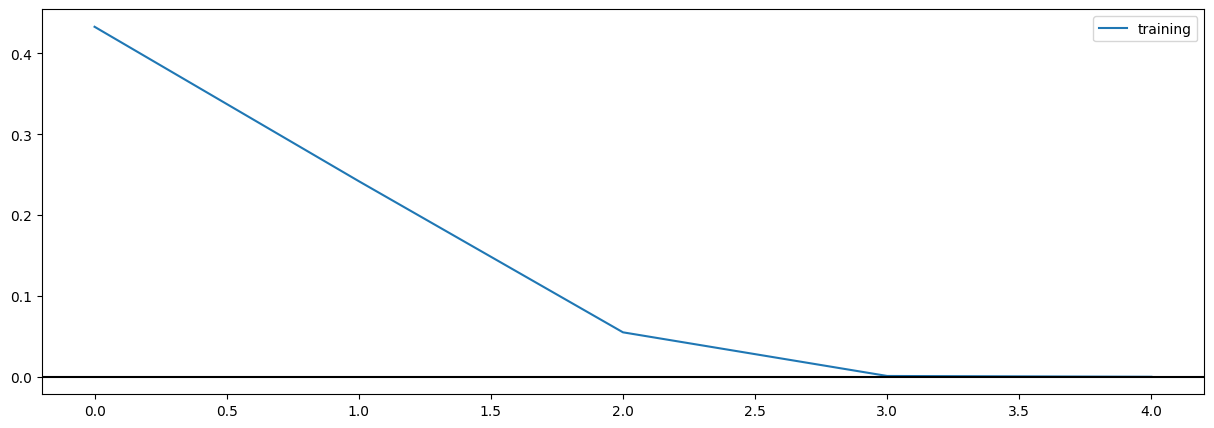

In [105]:
plt.figure(figsize=(15,5))
sns.lineplot(x=cost_info_dct['epoch'] ,y=cost_info_dct['cost'], label='training')
plt.axhline(0, color='black')

In [137]:
test_dataset, test_loader = get_data_loader(tgt_data=test_data[TGT_COLS], 
                feat_data=test_data[FEAT_COLS],
                batch_size=1,
                shuffle=False,
                is_rnn=True)

trn_data, trn_loader = get_data_loader(tgt_data=train_data[TGT_COLS], 
                feat_data=train_data[FEAT_COLS],
                batch_size=1,
                shuffle=False,
                is_rnn=True)

In [138]:



trn_pred_data = {'true_val':[],'pred_val':[]}
for trn_tgts, trn_feats in trn_loader:
    trn_pred = rnn_model(trn_feats)
    trn_pred_data['pred_val'].append(np.round(float(trn_pred[0][0].detach()),4))
    trn_pred_data['true_val'].append(float(trn_tgts[0][0].detach()))


trn_pred_data=pd.DataFrame(trn_pred_data)
trn_pred_data['index']=trn_pred_data.index

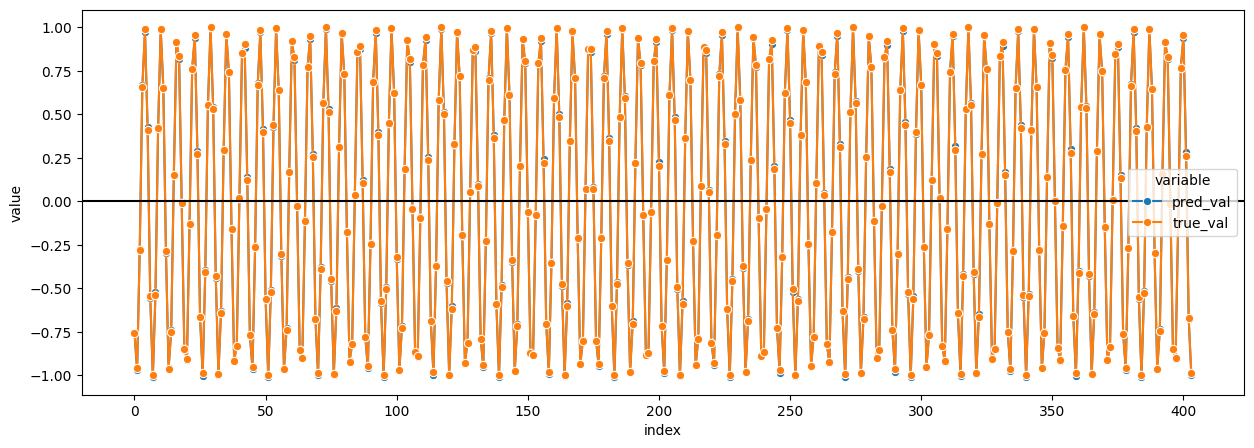

In [140]:
trn_plt_data = trn_pred_data.melt(id_vars='index',value_vars=['pred_val','true_val']).sort_values('index')

plt.figure(figsize=(15,5))
sns.lineplot(data=trn_plt_data, x='index' ,y='value', hue='variable', marker='o')
plt.axhline(0, color='black')

In [132]:

test_pred_data = {'true_val':[],'pred_val':[]}
for tst_tgts, tst_feats in test_loader:
    test_pred = rnn_model(tst_feats)
    test_pred_data['pred_val'].append(np.round(float(test_pred[0][0].detach()),4))
    test_pred_data['true_val'].append(float(tst_tgts[0][0].detach()))


test_pred_data=pd.DataFrame(test_pred_data)
test_pred_data['index']=test_pred_data.index

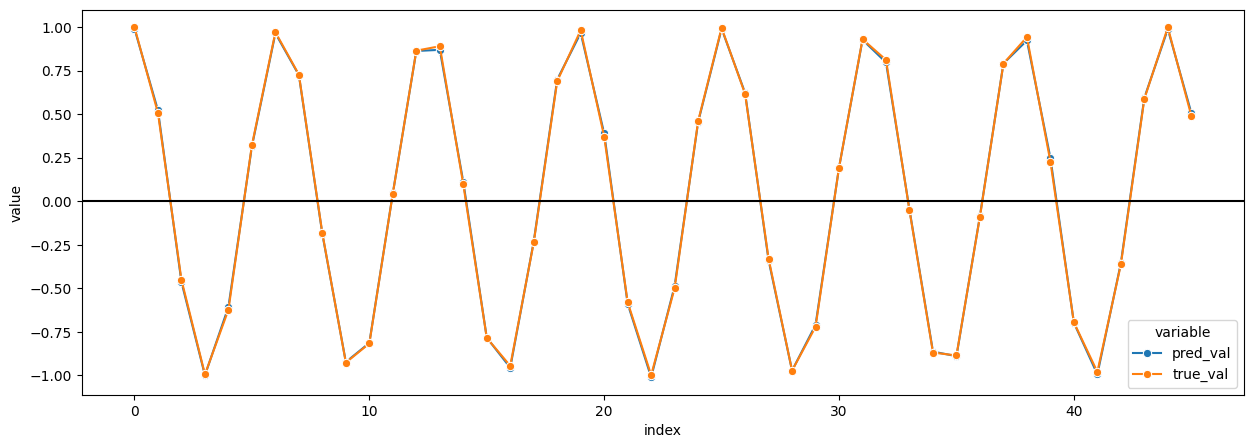

In [133]:
tst_plt_data = test_pred_data.melt(id_vars='index',value_vars=['pred_val','true_val'])

plt.figure(figsize=(15,5))
sns.lineplot(data=tst_plt_data, x='index' ,y='value', hue='variable', marker='o')
plt.axhline(0, color='black')

In [142]:
print('train SMAPE:',mean_absolute_percentage_error(y_pred=trn_pred_data['pred_val'], y_true=trn_pred_data['true_val'],symmetric=True))
print('test SMAPE:',mean_absolute_percentage_error(y_pred=test_pred_data['pred_val'], y_true=test_pred_data['true_val'],symmetric=True))

train SMAPE: 0.03081320031994102
test SMAPE: 0.02015973169049714
